<h1>Visualizando o Mapa de Saliência de Classe Específica na EfficientNet do PyTorch</h1>

A saliência em uma imagem refere-se ao que é perceptível ou importante para o sistema de visão computacional. Quando aplicado em redes neurais convolucionais, o mapa de saliência representa os pixels essenciais na imagem que influenciam a previsão da rede. Este código foi adaptado para criar mapas de saliência específicos para cada classe, com o objetivo de observar os pontos em que a rede concentra sua atenção ao classificar imagens de raio-x relacionadas à saúde óssea.

O projeto se concentra em melhorar a interpretabilidade das redes convolucionais ao permitir a visualização dos locais que a rede considera relevantes para a tomada de decisão em relação à saúde óssea. Essa técnica de mapa de saliência é valiosa para profissionais da área médica e pesquisadores, pois fornece insights sobre as características ou padrões específicos que a rede neural utiliza para realizar a classificação.

Fonte original do código: https://github.com/sunnynevarekar/pytorch-saliency-maps/tree/master

In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

In [2]:
MODEL_PATH = '/d01/scholles/gigasistemica/saved_models/BEST_AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600_Batch4_100Ep/RETESTE_AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600_Batch4_100Ep.pth'
MODEL = 'efficientnet-b7'

if MODEL == 'efficientnet-b0':
    RESIZE = (224, 224)
elif MODEL == 'efficientnet-b1':
    RESIZE = (240, 240)
elif MODEL == 'efficientnet-b2':
    RESIZE = (260, 260)
elif MODEL == 'efficientnet-b3':
    RESIZE = (300, 300)
elif MODEL == 'efficientnet-b4':
    RESIZE = (380, 380)
elif MODEL == 'efficientnet-b5':
    RESIZE = (456, 456)
elif MODEL == 'efficientnet-b6':
    RESIZE = (528, 528)
elif MODEL == 'efficientnet-b7':
    RESIZE = (600, 600)

if 'Saudavel_Doente_Grave' in MODEL_PATH:
    diagnosticos = {0: 'Osteoporose', 1: 'Osteopenia', 2: 'Saudável'}
elif 'DoenteGeral' in MODEL_PATH:
    diagnosticos = {0: 'Osso Doente (Osteoporose ou Osteopenia)', 1: 'Osso Saudável'}
else:
    diagnosticos = {0: 'Osteoporose detectada', 1: 'Osteoporose não detectada'}

#load pretrained resnet model
model = EfficientNet.from_pretrained(MODEL)
state_dict = torch.load(MODEL_PATH)
model.load_state_dict(state_dict)
#print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize(RESIZE),
    transforms.ToTensor(),
    normalize
])

Loaded pretrained weights for efficientnet-b7


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
        
    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
        
    imagem_hot = plt.cm.hot(slc)
    original = np.clip(np.transpose(input_img.detach().numpy(), (1, 2, 0)), 0, 1)

    # Multiplicar o canal vermelho da imagem "hot" pela intensidade desejada do vermelho
    intensity = 1.5  # Intensidade do vermelho (ajuste conforme necessário)
    red_channel = imagem_hot[:, :, 0] * intensity
    
    # Aplicar o threshold ao canal vermelho
    threshold = 0.3
    red_channel = np.where(red_channel < threshold, 0, red_channel)

    # Sobrepor o canal vermelho modificado na imagem original
    overlay = np.clip(original + red_channel[:, :, np.newaxis], 0, 1)
        
    # Plot the image, saliency map, and overlay
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image', fontweight='bold', color='white')
    
    plt.subplot(1, 3, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.title('Saliency Map', fontweight='bold', color='white')
    
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.xticks([])
    plt.yticks([])
    plt.title('Overlay', fontweight='bold', color='white')
    
    diagnosis = 'Diagnóstico: ' + diagnosticos[indices.item()]
    plt.suptitle(diagnosis, fontsize=40, y=1.05, fontweight='bold', color='white')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


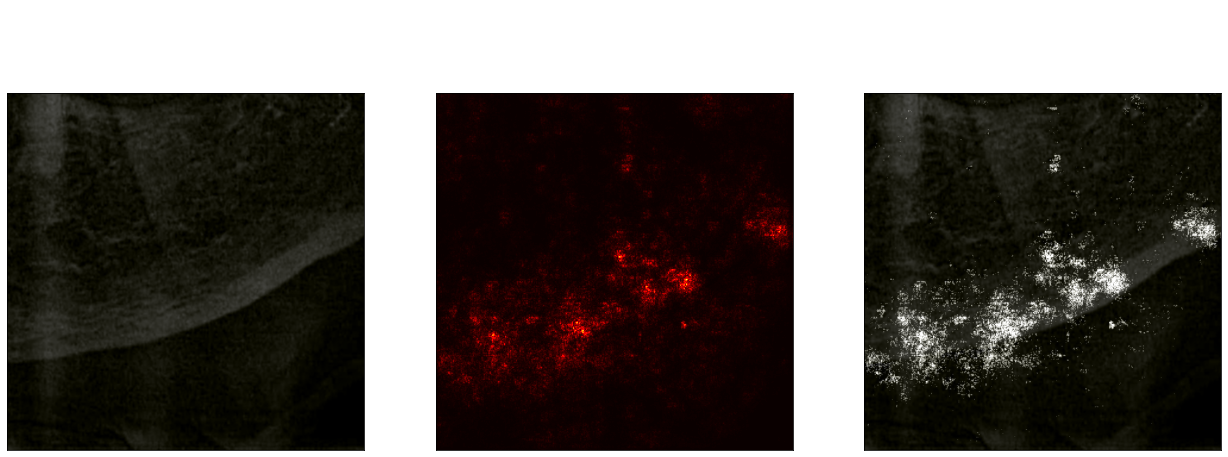

In [4]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Doente_Grave_Croped_600x600/val/Grave/OPHUB2019-461[1698.83, 1109.93, 427.47, 87.26].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


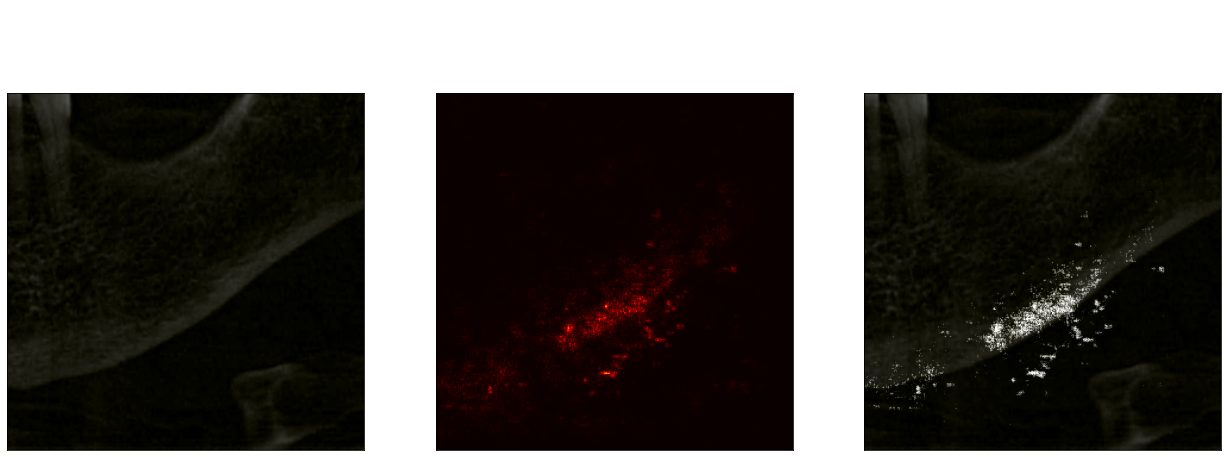

In [5]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Grave/OPHUB2021-1[1814.81, 1126.68, 392.56, 70.18].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


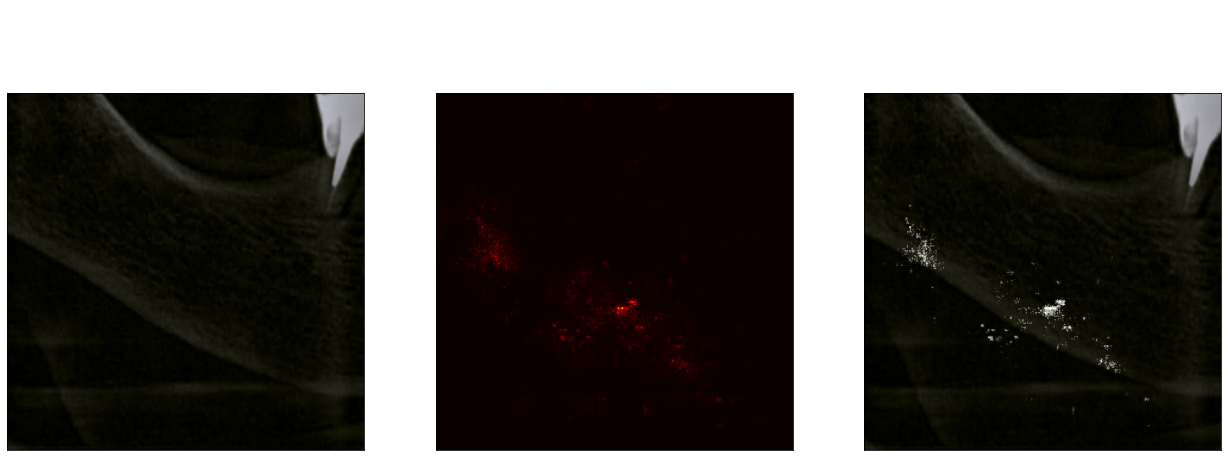

In [6]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Grave/OPHUB2021-1[700.16, 1153.94, 392.56, 70.18].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


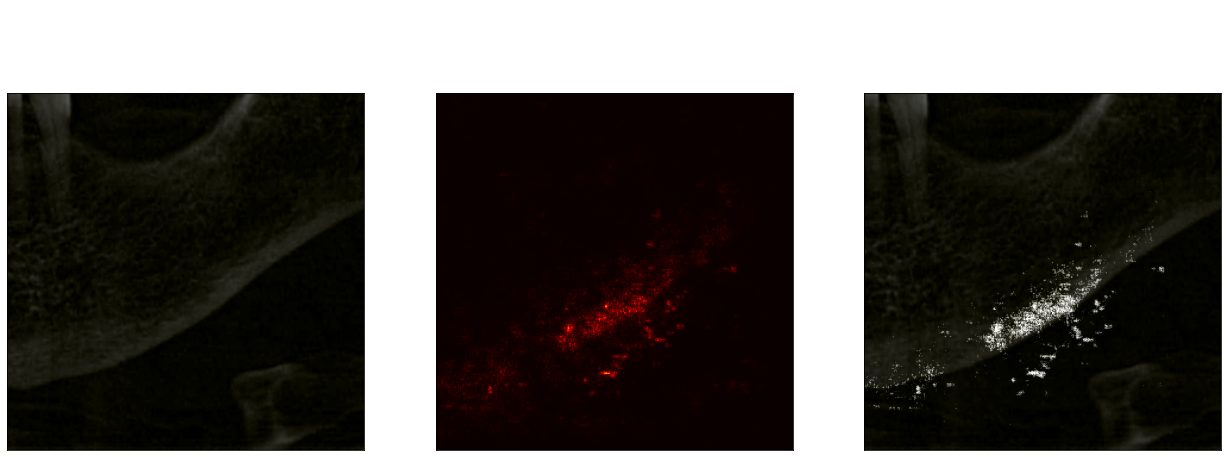

In [7]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Grave/OPHUB2021-1[1814.81, 1126.68, 392.56, 70.18].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


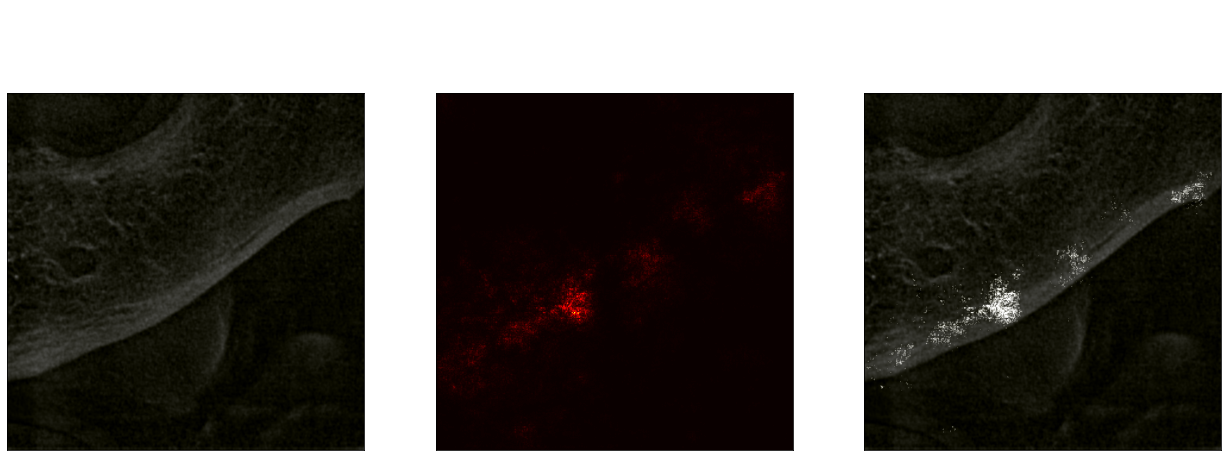

In [8]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Grave/OPHUB2022-2[1756.99, 1062.71, 390.75, 76.25].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


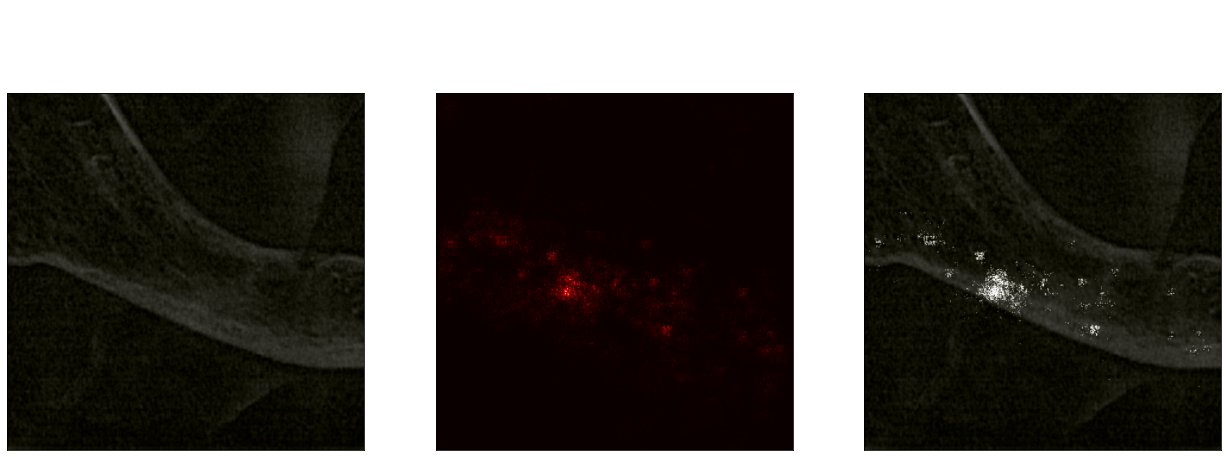

In [9]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/test/Grave/OPHUB2022-4[547.74, 1137.12, 449.34, 58.4].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


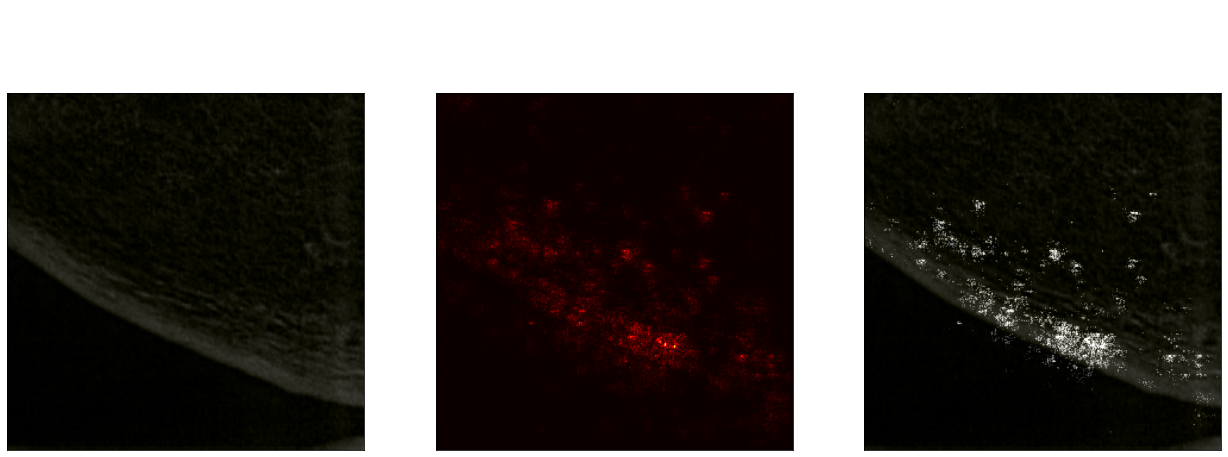

In [10]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Grave/OPHUB2022-3[514.18, 1166.31, 543.42, 63.45].jpg').convert('RGB')
saliency(img, model)

<h2>Sem Osteoporose</h2>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


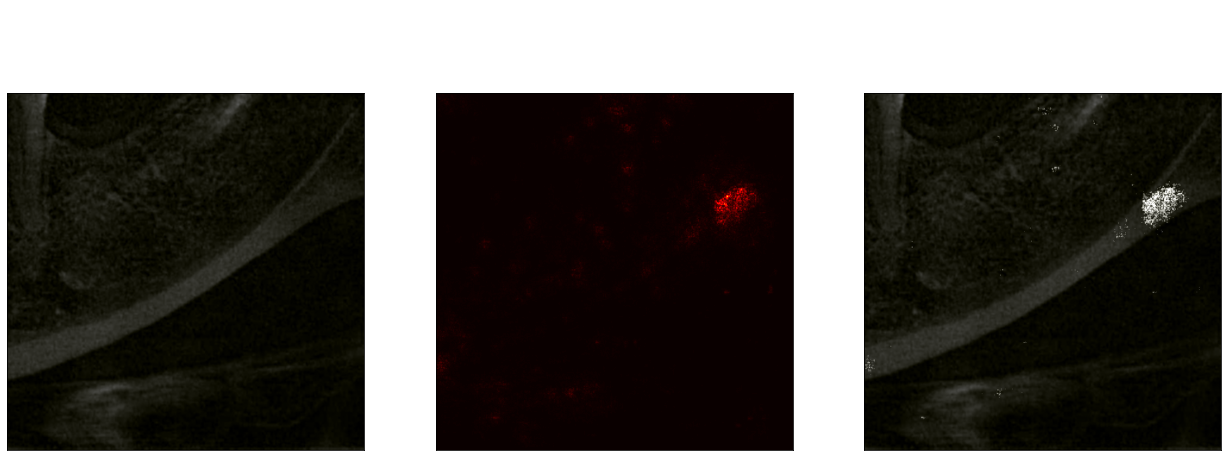

In [11]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Saudavel/OPHUB2019-362[1802.97, 1043.38, 456.69, 88.13].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


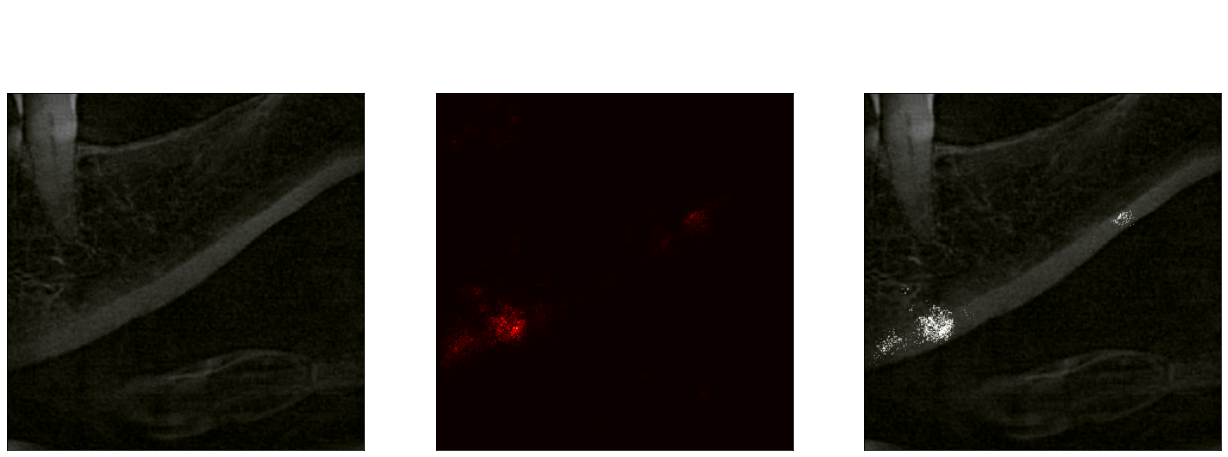

In [12]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Saudavel/OPHUB2019-398[1767.31, 999.82, 475.85, 83.18].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


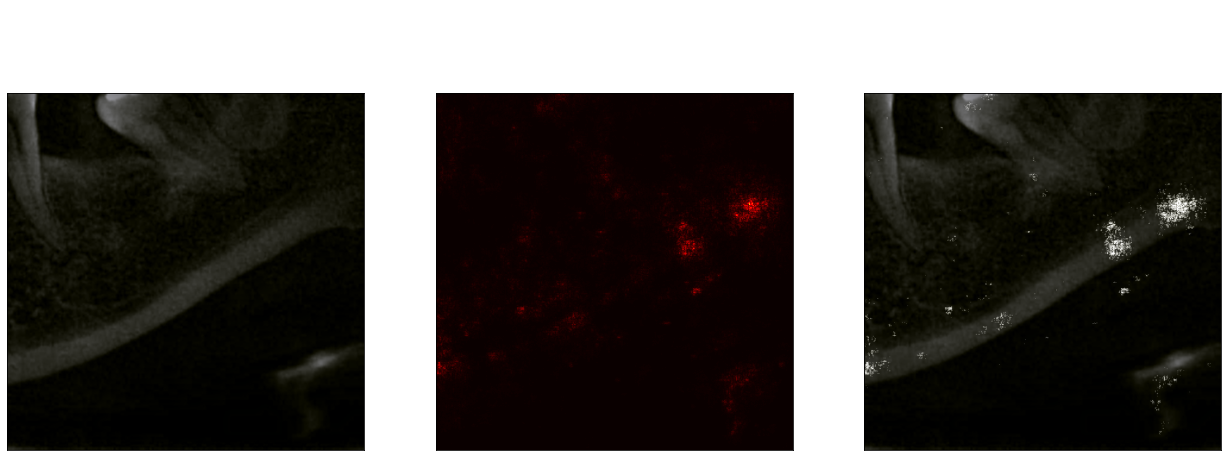

In [13]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Saudavel/OPHUB2019-405[1825.69, 1063.68, 440.06, 88.18].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


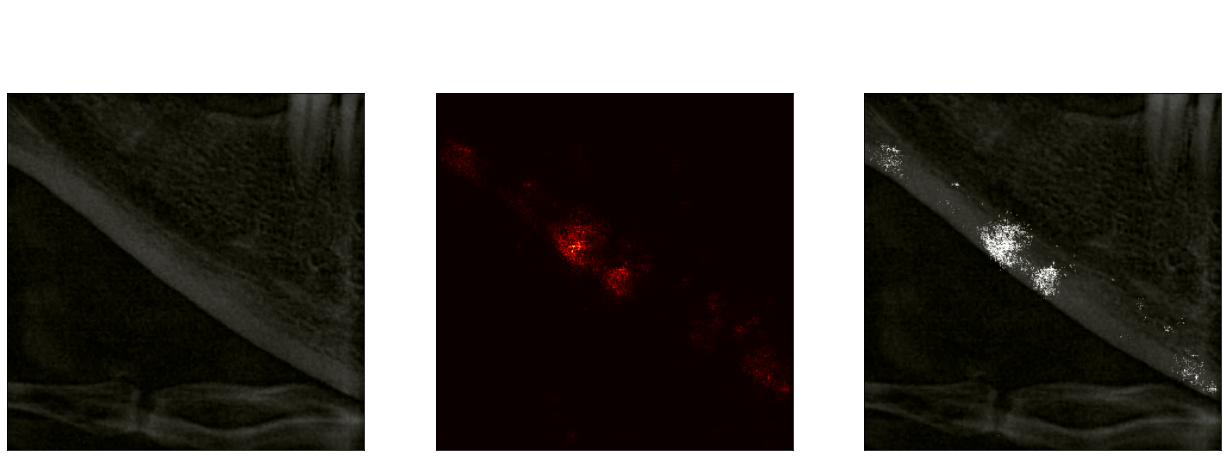

In [14]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Saudavel/OPHUB2019-377[628.08, 929.48, 514.22, 90.84].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


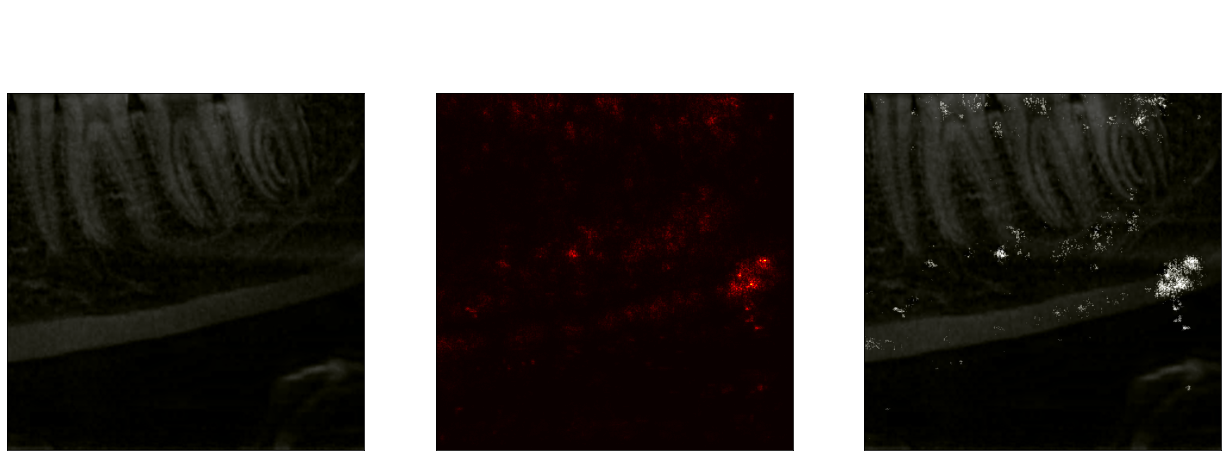

In [15]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Saudavel/OPHUB2019-399[1781.39, 1120.45, 528.8, 78.76].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


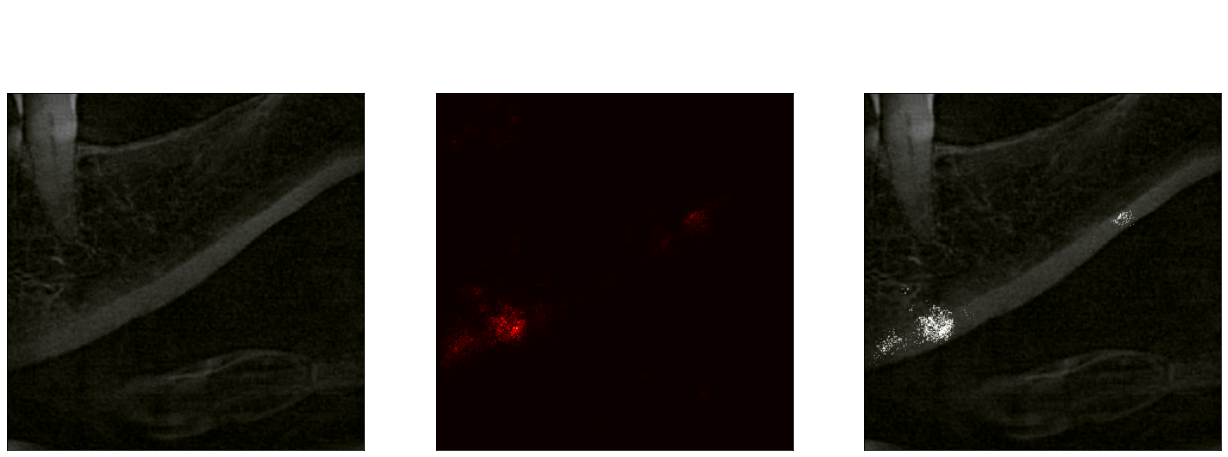

In [16]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Saudavel/OPHUB2019-398[1767.31, 999.82, 475.85, 83.18].jpg').convert('RGB')
saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


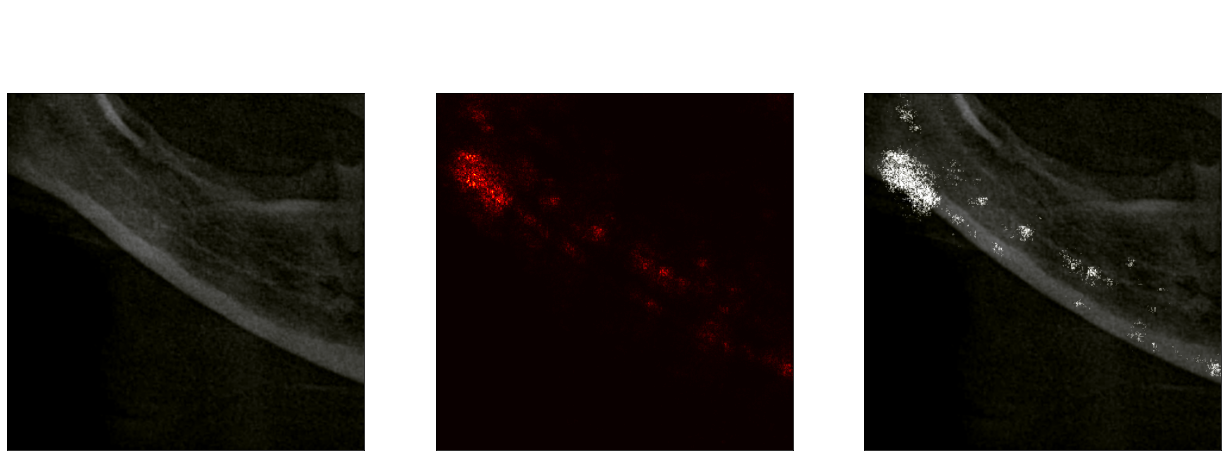

In [17]:
img = Image.open('/d01/scholles/gigasistemica/datasets/CVAT_train/augmented/AUG_RB_CVAT_Train_Saudavel_Grave_Croped_600x600/val/Saudavel/OPHUB2019-410[613.98, 963.55, 514.22, 84.35].jpg').convert('RGB')
saliency(img, model)